In [52]:
import pandas as pd 
df=pd.read_csv("Transactions (1).csv",index_col=0)
df=df.loc[(df['trans_group_en']=="Sales")|(df['trans_group_en']=="Rent")]
df.instance_date=pd.to_datetime(df.instance_date)

df=df.sort_values(by='instance_date')
df=df.loc[(df.instance_date.dt.year>=2022) & (df.instance_date.dt.year<2023)]

print("start_dated",df.instance_date.min())
print("start_dated",df.instance_date.max())




start_dated 2022-01-03 00:00:00
start_dated 2022-12-30 00:00:00


In [53]:
import numpy as np
print(df.shape)

##REMOVING ARABIC NAMES TO AVOID REDUNDANCY (BECAUSE I DONT UNDERSTAMND THEM YET)

strings_to_drop=['_ar','_parties']
df = df.drop(columns=[col for col in df.columns if any(s in col for s in strings_to_drop)])

df.sample(5)
df.columns=df.columns.str.upper()
print(df.columns)
print(df.shape)

(95939, 45)
Index(['PROCEDURE_ID', 'TRANS_GROUP_ID', 'TRANS_GROUP_EN', 'PROCEDURE_NAME_EN',
       'INSTANCE_DATE', 'PROPERTY_TYPE_ID', 'PROPERTY_TYPE_EN',
       'PROPERTY_SUB_TYPE_ID', 'PROPERTY_SUB_TYPE_EN', 'PROPERTY_USAGE_EN',
       'REG_TYPE_ID', 'REG_TYPE_EN', 'AREA_ID', 'AREA_NAME_EN',
       'BUILDING_NAME_EN', 'PROJECT_NUMBER', 'PROJECT_NAME_EN',
       'MASTER_PROJECT_EN', 'NEAREST_LANDMARK_EN', 'NEAREST_METRO_EN',
       'NEAREST_MALL_EN', 'ROOMS_EN', 'HAS_PARKING', 'ACTUAL_WORTH',
       'METER_SALE_PRICE', 'RENT_VALUE', 'METER_RENT_PRICE'],
      dtype='object')
(95939, 27)


In [54]:
# df.plot()
col_names=df.columns

print(col_names)
print(df.shape)
df.head(100)
pd.set_option('display.max_colwidth', None)


Index(['PROCEDURE_ID', 'TRANS_GROUP_ID', 'TRANS_GROUP_EN', 'PROCEDURE_NAME_EN',
       'INSTANCE_DATE', 'PROPERTY_TYPE_ID', 'PROPERTY_TYPE_EN',
       'PROPERTY_SUB_TYPE_ID', 'PROPERTY_SUB_TYPE_EN', 'PROPERTY_USAGE_EN',
       'REG_TYPE_ID', 'REG_TYPE_EN', 'AREA_ID', 'AREA_NAME_EN',
       'BUILDING_NAME_EN', 'PROJECT_NUMBER', 'PROJECT_NAME_EN',
       'MASTER_PROJECT_EN', 'NEAREST_LANDMARK_EN', 'NEAREST_METRO_EN',
       'NEAREST_MALL_EN', 'ROOMS_EN', 'HAS_PARKING', 'ACTUAL_WORTH',
       'METER_SALE_PRICE', 'RENT_VALUE', 'METER_RENT_PRICE'],
      dtype='object')
(95939, 27)


<Axes: xlabel='transaction_id'>

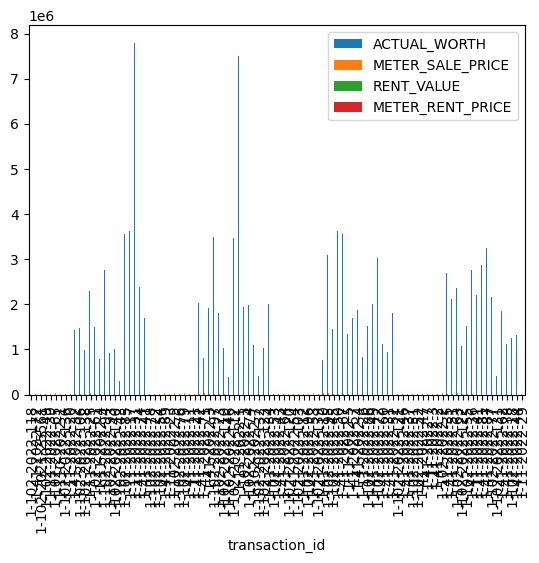

In [55]:
# df['AREA_NAME_EN'].nunique()
df[['ACTUAL_WORTH',
       'METER_SALE_PRICE', 'RENT_VALUE', 'METER_RENT_PRICE']].head(100).plot(kind='bar')

In [56]:
###convert to boolean to improve feature value
import numpy as np

def add_prox_feats(df):
    ## determine proximity to city based on proximity to malls
    df['Near_city'] = np.where(df['NEAREST_MALL_EN'].isna(), 'No', 'Yes')
    df['Near_metro'] = np.where(df['NEAREST_METRO_EN'].isna(), 'No', 'Yes')

    return(df)


In [57]:
import warnings
warnings.filterwarnings('ignore')

###Create proximity related features assuming distance to malls shows city area
df=add_prox_feats(df)


feat_column_names= [col for col in df.columns if col not in ['PROCEDURE_ID','TRANS_GROUP_ID','PROPERTY_TYPE_ID','PROPERTY_SUB_TYPE_ID','REG_TYPE_ID','INSTANCE_DATE','NEAREST_METRO_EN', 'NEAREST_MALL_EN',
       'PROJECT_NAME_EN', 'PROCEDURE_NAME_EN', 'IS_OFFPLAN_EN', 'IS_FREE_HOLD_EN', 'MASTER_PROJECT_EN', 'AREA_ID', 'BUILDING_NAME_EN', 'PROJECT_NUMBER','ACTUAL_WORTH','RENT_VALUE']]

print(feat_column_names)
for i in feat_column_names:
    print(df[i].nunique())
df=df[feat_column_names]
#df[['NEAREST_METRO_EN', 'NEAREST_MALL_EN','NEAREST_LANDMARK_EN','PROJECT_EN', 'PROCEDURE_EN', 'IS_OFFPLAN_EN', 'IS_FREE_HOLD_EN','AREA_EN', 'MASTER_PROJECT_EN']].info()

['TRANS_GROUP_EN', 'PROPERTY_TYPE_EN', 'PROPERTY_SUB_TYPE_EN', 'PROPERTY_USAGE_EN', 'REG_TYPE_EN', 'AREA_NAME_EN', 'NEAREST_LANDMARK_EN', 'ROOMS_EN', 'HAS_PARKING', 'METER_SALE_PRICE', 'METER_RENT_PRICE', 'Near_city', 'Near_metro']
1
4
14
11
2
168
14
13
2
74765
0
2
2


In [58]:
##have a single dataframe with group_en added as first grouping layer

df_sales=df.loc[df.TRANS_GROUP_EN=='Sales']

print("sales_data",df_sales.shape)

sales_data (95939, 13)


In [59]:
df_sales.AREA_NAME_EN.nunique()

168

In [60]:
df_sales=df_sales.dropna(how='all')

print(df_sales.columns)
# ##REMOVE OBVIOUS OUTLIERS (UNIVARIATE)
# def remove_outliers(df,column):
  
#     Q1 = df[column].quantile(0.25) 
#     Q3 = df[column].quantile(0.75) 
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR 
#     upper_bound = Q3 + 1.5 * IQR 
#     return df[(df[column] >= lower_bound) & (df[column]
#                                             <= upper_bound)]

Index(['TRANS_GROUP_EN', 'PROPERTY_TYPE_EN', 'PROPERTY_SUB_TYPE_EN',
       'PROPERTY_USAGE_EN', 'REG_TYPE_EN', 'AREA_NAME_EN',
       'NEAREST_LANDMARK_EN', 'ROOMS_EN', 'HAS_PARKING', 'METER_SALE_PRICE',
       'METER_RENT_PRICE', 'Near_city', 'Near_metro'],
      dtype='object')


In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer



# Identify numeric and categorical columns
numeric_features = df_sales.select_dtypes(include=['float64', 'int64']).columns
print(numeric_features)
categorical_features = df_sales.select_dtypes(include=['object']).columns

# Initialize StandardScaler and OneHotEncoder
scaler = StandardScaler()
encoder = OneHotEncoder()

# Apply StandardScaler to numerical features
df_sales_num_scaled = pd.DataFrame(scaler.fit_transform(df_sales[numeric_features]), columns=numeric_features)

# Apply OneHotEncoder to categorical features
df_sales_cat_encoded = pd.DataFrame(encoder.fit_transform(df_sales[categorical_features]).toarray(),
                                    columns=encoder.get_feature_names_out(categorical_features))

# Combine the scaled numerical and encoded categorical features
df_processed = pd.concat([df_sales_num_scaled, df_sales_cat_encoded], axis=1)

# Check the resulting processed data
print(df_processed.sample(5))


Index(['HAS_PARKING', 'METER_SALE_PRICE', 'METER_RENT_PRICE'], dtype='object')
       HAS_PARKING  METER_SALE_PRICE  METER_RENT_PRICE  TRANS_GROUP_EN_Sales  \
73116     0.658186          0.569220               NaN                   1.0   
58131     0.658186         -0.255987               NaN                   1.0   
10710     0.658186          0.242684               NaN                   1.0   
63840     0.658186          0.859542               NaN                   1.0   
23591     0.658186         -0.519372               NaN                   1.0   

       PROPERTY_TYPE_EN_Building  PROPERTY_TYPE_EN_Land  \
73116                        0.0                    0.0   
58131                        0.0                    0.0   
10710                        0.0                    0.0   
63840                        0.0                    0.0   
23591                        0.0                    0.0   

       PROPERTY_TYPE_EN_Unit  PROPERTY_TYPE_EN_Villa  \
73116                    1.0 

In [62]:
# Use Isolation Forest
iforest=IsolationForest(contamination=0.01)
iforest.fit(df_processed)

df_processed['anomaly_score'] = iforest.fit_predict(df_processed)

In [63]:
anomalies=(df_processed.loc[df_processed['anomaly_score']==-1])
print("size of anomaly data",anomalies.shape)
anomalies.to_csv('anomalies.csv')
anomalies_index = df_processed.loc[df_processed.anomaly_score == -1].index.to_list() 
# print(type(anomalies_index))
anomalies_df_sales = df_processed.loc[anomalies_index] # Add row numbers to anomalies DataFrame 
display(anomalies_df_sales.sample(10))

# Inverse transform categorical columns 
inverse_cat = encoder.inverse_transform(anomalies_df_sales[encoder.get_feature_names_out(categorical_features)]) 
##Combine inverse transformed categorical with numerical data 
anomalies_original = pd.concat([pd.DataFrame(scaler.inverse_transform(anomalies[numeric_features]), columns=numeric_features), pd.DataFrame(inverse_cat, columns=categorical_features)], axis=1) 
# View original rows with anomalies

anomalies_original.shape
anomalies_original.columns
print("sales_data_count",df_sales.shape)
print("anaomaly_count",anomalies_original.shape)

anomalies_original.to_csv("anomalies.csv")

size of anomaly data (927, 238)


,HAS_PARKING,METER_SALE_PRICE,METER_RENT_PRICE,TRANS_GROUP_EN_Sales,PROPERTY_TYPE_EN_Building,PROPERTY_TYPE_EN_Land,PROPERTY_TYPE_EN_Unit,PROPERTY_TYPE_EN_Villa,PROPERTY_SUB_TYPE_EN_Building,PROPERTY_SUB_TYPE_EN_Clinic,...,ROOMS_EN_PENTHOUSE,ROOMS_EN_Shop,ROOMS_EN_Single Room,ROOMS_EN_Studio,ROOMS_EN_nan,Near_city_No,Near_city_Yes,Near_metro_No,Near_metro_Yes,anomaly_score
78721,-1.519327,6.705385,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
8381,-1.519327,6.672233,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
49110,-1.519327,5.871391,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
50074,-1.519327,5.695384,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
43954,-1.519327,5.430675,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
21020,-1.519327,6.006252,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1
85433,0.658186,-0.110337,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1
22988,0.658186,-1.123379,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1
85623,-1.519327,-0.860756,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1
69096,-1.519327,-0.589392,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1


sales_data_count (95939, 13)
anaomaly_count (927, 13)


##Validation of anomalies identified

<Axes: xlabel='count', ylabel='AREA_NAME_EN'>

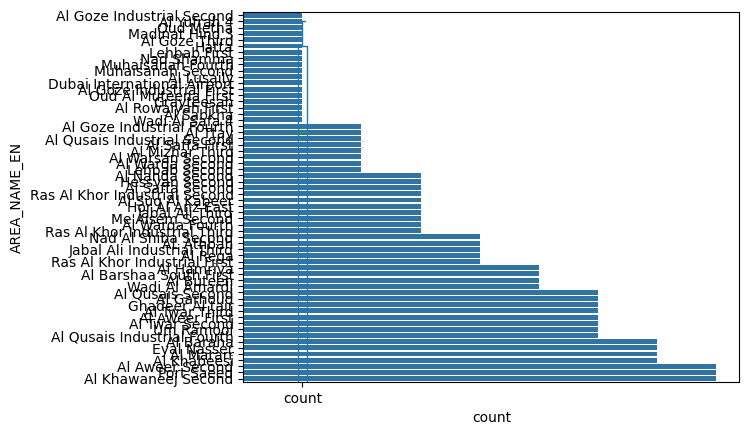

In [64]:
## valdiate anomaly results
import seaborn as sns
df_sales.AREA_NAME_EN.value_counts().plot(kind='box')
sns.countplot(data=df_sales,y='AREA_NAME_EN',order=df_sales.AREA_NAME_EN.value_counts().nsmallest(60).index)


,AREA_NAME_EN,PROPERTY_TYPE_EN,METER_SALE_PRICE
12,Business Bay,Unit,59128.98


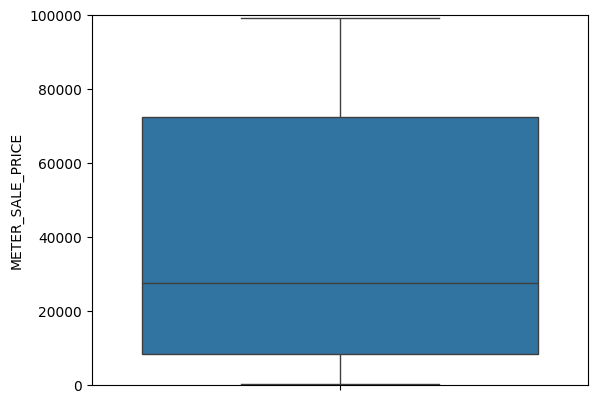

In [65]:

import matplotlib.pyplot as plt
anom_grpd = anomalies_original.groupby(['AREA_NAME_EN', 'PROPERTY_TYPE_EN'])['METER_SALE_PRICE'].mean().reset_index()

sns.boxplot(data=anomalies_original,y='METER_SALE_PRICE')
plt.ylim(0,100000)

##QUICK VALIDATION STEP 
display(anom_grpd.loc[anom_grpd.AREA_NAME_EN=='Business Bay'])

,AREA_NAME_EN,PROPERTY_TYPE_EN,METER_SALE_PRICE
202,Business Bay,Building,31767.195000
203,Business Bay,Land,16319.313333
204,Business Bay,Unit,19114.392686


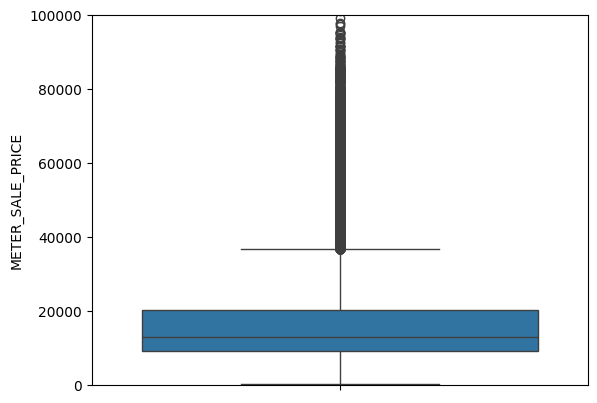

In [66]:

sns.boxplot(data=df_sales,y='METER_SALE_PRICE')
plt.ylim(0,100000)
df_sales_grpd = df_sales.groupby(['AREA_NAME_EN', 'PROPERTY_TYPE_EN'])['METER_SALE_PRICE'].mean().reset_index()


df_sales_grpd.loc[df_sales_grpd.AREA_NAME_EN=='Business Bay']
